<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/SimulateImpScores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install modisco

     |████████████████████████████████| 215 kB 4.1 MB/s 
     |████████████████████████████████| 1.4 MB 40.6 MB/s 
     |████████████████████████████████| 3.2 MB 15.8 MB/s 
  Created wheel for modisco: filename=modisco-0.5.15.0-py3-none-any.whl size=231925 sha256=270c6ead99ba8efdbd53fbf9ef08ed37ca7976493e859c1324f0e4cb300e7552
  Stored in directory: /root/.cache/pip/wheels/67/53/04/50094050522f2faf148096dd88651c1674c3c7a619a5c5377a
Successfully built modisco


In [1]:
!pip uninstall -y simdna
%cd /content/
!rm -rf simdna
!git clone https://github.com/kundajelab/simdna.git
%cd /content/simdna
!git checkout dev
!git log -1
!pip install .
%cd /content/

from importlib import reload
%load_ext autoreload
%autoreload 2

/content
Cloning into 'simdna'...
remote: Enumerating objects: 1234, done.
remote: Counting objects: 100% (340/340), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 1234 (delta 167), reused 236 (delta 99), pack-reused 894
Receiving objects: 100% (1234/1234), 4.02 MiB | 5.38 MiB/s, done.
Resolving deltas: 100% (695/695), done.
/content/simdna
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
commit e8488eba5eae123bc798bcbbdbc580497352608b (HEAD -> dev, origin/dev)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Wed Sep 29 17:20:03 2021 -0700

    super fix
Processing /content/simdna
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discuss

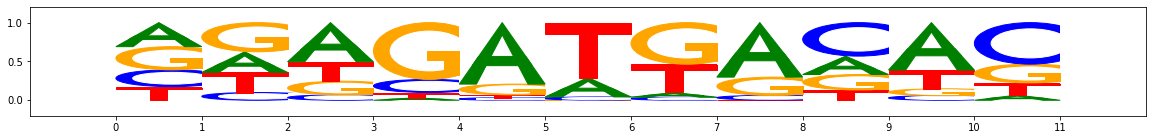

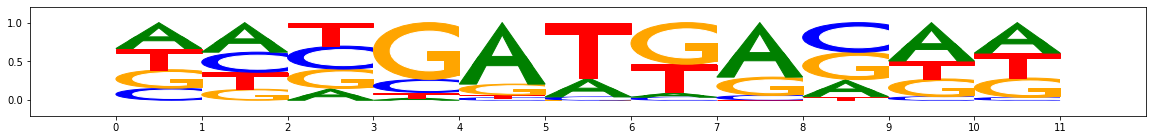

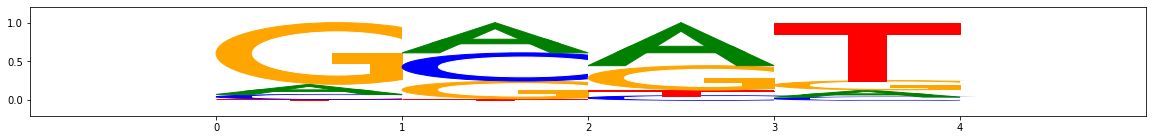

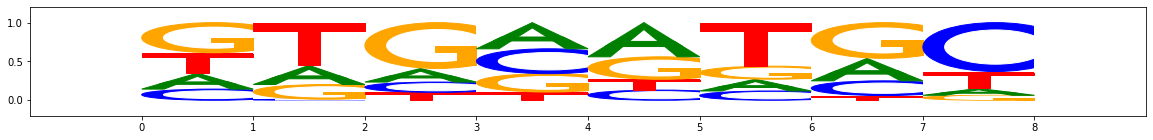

In [200]:
#motifs of varying lengths
#and of varying frequencies

import numpy as np
from modisco.visualization import viz_sequence

rng = np.random.RandomState(1234)

def generate_ppm(rng, length, alpha):
    return rng.dirichlet(alpha*np.ones(4), size=length)

def gen_motif_with_diff_flanks(rng, core_len, core_alpha,
                                    flank_len, flank_alpha):
  motifcore = generate_ppm(rng, length=core_len, alpha=0.5)
  motifa = np.concatenate([
              generate_ppm(rng, length=flank_len, alpha=flank_alpha),
                motifcore,
              generate_ppm(rng, length=flank_len, alpha=flank_alpha)])
  motifb = np.concatenate([
              generate_ppm(rng, length=flank_len, alpha=flank_alpha),
                motifcore,
              generate_ppm(rng, length=flank_len, alpha=flank_alpha)])
  return motifa, motifb

def gen_motif_with_lower_ic_and_diff_flanks(rng, core_len, core_alpha, flank_len,
                                            flank_alpha, core_pc):
  motif_core = generate_ppm(rng, length=core_len, alpha=core_alpha)
  degraded_core = (motif_core +
                   np.array([core_pc, core_pc,
                             core_pc, core_pc])[None,:])/(1.0 + core_pc*4)
  motifa = np.concatenate([
              generate_ppm(rng, length=flank_len, alpha=flank_alpha),
                degraded_core,
              generate_ppm(rng, length=flank_len, alpha=flank_alpha)])
  return motif_core, motifa

motif1a, motif1b = gen_motif_with_diff_flanks(
                      rng=rng, core_len=5,
                      core_alpha=0.5, flank_len=3, flank_alpha=2.0)
viz_sequence.plot_weights(motif1a)
viz_sequence.plot_weights(motif1b)


motif2a, motif2b = gen_motif_with_lower_ic_and_diff_flanks(
                      rng=rng, core_len=4,
                      core_alpha=0.5, flank_len=2, flank_alpha=1.0,
                      core_pc=0.15) #core_pc is 'core_pseudocount'

viz_sequence.plot_weights(motif2a)
viz_sequence.plot_weights(motif2b)

"""motif3 = np.concatenate([generate_ppm(rng, length=3, alpha=2.0),
                         generate_ppm(rng, length=9, alpha=0.5),
                         generate_ppm(rng, length=3, alpha=2.0)])
viz_sequence.plot_weights(motif3)

motif4 = np.concatenate([generate_ppm(rng, length=2, alpha=2.0),
                         generate_ppm(rng, length=11, alpha=0.7),
                         generate_ppm(rng, length=2, alpha=2.0)])
viz_sequence.plot_weights(motif4)

motif5 = np.concatenate([generate_ppm(rng, length=1, alpha=2.0),
                         generate_ppm(rng, length=13, alpha=0.7),
                         generate_ppm(rng, length=1, alpha=2.0)])
viz_sequence.plot_weights(motif5)

motif6 = np.concatenate([generate_ppm(rng, length=5, alpha=0.5),
                         generate_ppm(rng, length=5, alpha=2.0),
                         generate_ppm(rng, length=5, alpha=0.5)])
viz_sequence.plot_weights(motif6)"""


motifs = [motif1a, motif1b, motif2a, motif2b]#, motif3, motif4, motif5, motif6]

In [201]:
#generate simulate sequences
from importlib import reload
import simdna
reload(simdna.synthetic.substringgen)
#reload(simdna.synthetic.embedders)
from simdna.simdnautil.pwm import PWM
import simdna.synthetic as sn
import simdna

rng = np.random.RandomState(1234)

simdnapwmembedders = [sn.SubstringEmbedder(sn.PwmSampler(
                       PWM(name="motif"+str(idx),probMatrix=motif,
                           pseudocountProb=0.0)),
                           positionGenerator=sn.InsideCentralBp(centralBp=200))
                      for idx,motif in enumerate(motifs)]
relative_probs = rng.dirichlet(alpha=np.ones(len(motifs))*5)
print("Motif relative probs:", relative_probs)
embedder = sn.RandomSubsetOfEmbedders(
              quantityGenerator=3, embedders=simdnapwmembedders,
              probs=relative_probs)
simulator = sn.EmbedInABackground(
    backgroundGenerator=sn.ZeroOrderBackgroundGenerator(
        seqLength=300,
        discreteDistribution={'A':0.27, 'C':0.23, 'G':0.23, 'T': 0.27}),
        embedders=[embedder])

sn.print_sequences(
    outputFileName="mysim.simdna",
    sequenceSetGenerator=sn.GenerateSequenceNTimes(simulator, N=1000),
    includeEmbeddings=True)

Motif relative probs: [0.31253802 0.13767331 0.17776343 0.37202525]


In [202]:
bgsimulator = sn.EmbedInABackground(
    backgroundGenerator=sn.ZeroOrderBackgroundGenerator(
        seqLength=300,
        discreteDistribution={'A':0.27, 'C':0.23, 'G':0.23, 'T': 0.27}),
        embedders=[])

sn.print_sequences(
    outputFileName="bgsim.simdna",
    sequenceSetGenerator=sn.GenerateSequenceNTimes(bgsimulator, N=1000),
    includeEmbeddings=True)

In [203]:
simdata = sn.read_simdata_file("mysim.simdna")
bgdata = sn.read_simdata_file("bgsim.simdna")

In [204]:
seqs = simdata.sequences

#one-hot encode the seqs
import numpy as np
lookup = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1]}
def onehotencode_seqs(seqs):
  to_return = []
  for seq in seqs:
    to_return.append([lookup[letter] for letter in seq])
  return np.array(to_return)

fg_onehot_seqs = onehotencode_seqs(simdata.sequences)
bg_onehot_seqs = onehotencode_seqs(bgdata.sequences)

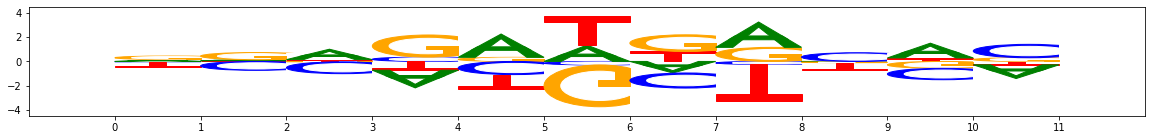

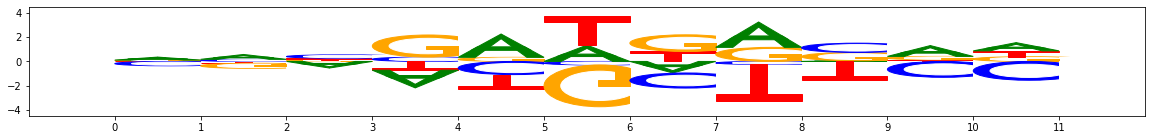

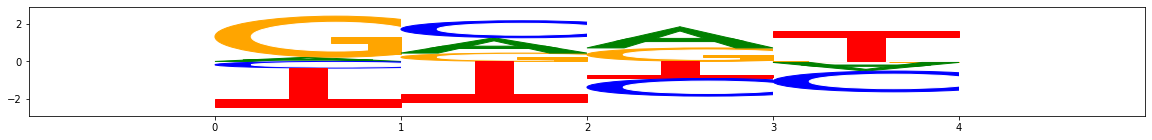

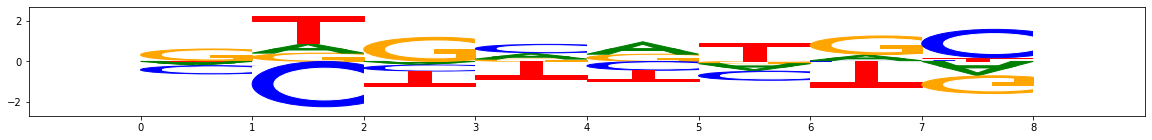

In [205]:
#score each sequence with the log-odds matrix of each pfm
background = np.array([0.27, 0.23, 0.23, 0.27])
pwms = [np.log(motif/background) for motif in motifs]
for pwm in pwms:
  viz_sequence.plot_weights(pwm - np.mean(pwm, axis=-1)[:,None])

In [206]:
#scan each sequence with the rolling window sums. 
import modisco
import numpy as np
import scipy
from collections import namedtuple


PwmHit = namedtuple("PwmHit", ["seq_idx", "pwm_start", "pwm_end", "which_pwm",
                                         "logodds_score"])


def get_pwm_hits_for_seq(seq_pwm_axis_argmax, seq_pwm_axis_maxlogodds,
                         pwm_offsets, pwm_lengths, competition_window,
                         seq_idx):
    #Greedily decide which motifs get to bind
    #Pwm offsets should be the left padding that was applied to the logodds
    # scores for that particular pwm (depends on the pwm length)
    #seq_idx just to insert into the hit
    maxlogodds_copy = np.copy(seq_pwm_axis_maxlogodds)
    sorted_positions = np.argsort(-maxlogodds_copy)
    
    pwm_hits = []
    for pos in sorted_positions:
        logodds_score = maxlogodds_copy[pos]
        if (logodds_score <= 0): #avoid 'less likely than bg' hits for this sim
            continue
        which_pwm = seq_pwm_axis_argmax[pos]
        #we want pwm_hits to represent the pwm start, hence the subtraction
        # of pwm_offsets
        pwm_start = pos-pwm_offsets[which_pwm]
        pwm_hits.append(PwmHit(seq_idx=seq_idx,
                               pwm_start=pwm_start,
                               pwm_end=pwm_start+pwm_lengths[which_pwm],
                               which_pwm=which_pwm,
                               logodds_score=logodds_score))
        clearance_start = pos - int(competition_window/2.0)
        clearance_end = clearance_start + competition_window
        maxlogodds_copy[clearance_start:clearance_end] = 0
    return pwm_hits


def scan_sequences(onehot_seqs, pwms):
  logodds_scans = []
  #pwm_scans = []
  for pwm in pwms:
    logodds_scans.append(modisco.util.compute_pwm_scan(onehot_seq=onehot_seqs,
                                                       weightmat=pwm))
    #pwm_scans.append( np.exp(expfactor*scipy.special.expit(logodds_scans[-1]+mu)) )
  return logodds_scans#, pwm_scans


def get_competitive_pwm_hits(onehot_seqs, pwms, competition_window):
    #Scan the sequences for logodds. Then:
    # (1) simulate competitive binding, in that only one motif is allowed to bind
    # in a window of length "competition_window" (centered at the motif)
    # (2) Decide which motif gets to bind greedily.
    
    logodds_scans = scan_sequences(onehot_seqs=onehot_seqs, pwms=pwms)
    pwm_lengths = [len(x) for x in pwms]

    #When a sequences is scanned,
    # the length of the result is orig_len-(windowlen-1). So we distribute
    # (windowlen-1) evenly on either side to make up for it.
    padded_logodds_scans = []
    pwm_offsets = [] #record the left-padding applied
    for (logodds_scan, pwm_len) in zip(logodds_scans, pwm_lengths):
      pwm_offset = int((pwm_len-1)/2.0)
      pwm_offsets.append(pwm_offset)
      padded_logodds_scans.append(
          np.pad(np.array(logodds_scan), (
            (0,0), (pwm_offset, (pwm_len-1)-pwm_offset )))
      )
    #assert that after padding they are all the same length. This will also make
    # the scores represent the score at the center of the pwm hit rather than
    # at the start.
    assert len(set(x.shape[1] for x in padded_logodds_scans)) == 1
    #make them all one numpy array so we can take an argmax over the pwm axis
    padded_logodds_scans = np.array(padded_logodds_scans)
    pwm_axis_argmax = np.argmax(padded_logodds_scans, axis=0)
    pwm_axis_maxlogodds = np.max(padded_logodds_scans, axis=0)
    allseq_pwm_hits = [
      get_pwm_hits_for_seq(seq_pwm_axis_argmax, seq_pwm_axis_maxlogodds,
                           pwm_offsets=pwm_offsets, pwm_lengths=pwm_lengths,
                           competition_window=competition_window,
                           seq_idx=seq_idx)
      for (seq_idx, (seq_pwm_axis_argmax, seq_pwm_axis_maxlogodds)) in
      enumerate(zip(pwm_axis_argmax, pwm_axis_maxlogodds))
    ]

    #reorganize to be pwm-to-hits
    pwm_to_hits = [[] for pwm in pwms]
    for seq_idx, pwm_hits_for_seq in enumerate(allseq_pwm_hits):
      for pwm_hit in pwm_hits_for_seq:
        pwm_to_hits[pwm_hit.which_pwm].append(pwm_hit)

    return allseq_pwm_hits, pwm_to_hits


COMPETITION_WINDOW = max([len(x) for x in pwms])

(fg_allseq_pwm_hits, fg_pwm_to_hits) = get_competitive_pwm_hits(
    onehot_seqs=fg_onehot_seqs, pwms=pwms,
    competition_window=COMPETITION_WINDOW)
(bg_allseq_pwm_hits, bg_pwm_to_hits) = get_competitive_pwm_hits(
    onehot_seqs=bg_onehot_seqs, pwms=pwms,
    competition_window=COMPETITION_WINDOW)

print("sumscore hits in fg")
print([np.sum([y.logodds_score for y in x]) for x in fg_pwm_to_hits])

print("sumscore hits in bg")
print([np.sum([y.logodds_score for y in x]) for x in bg_pwm_to_hits])

#for logodds_scan in fg_logodds_scans:
#  print(np.sum(logodds_scan+mu > 0)) #instances of "positive" hits
#print("hits in bg")
#for logodds_scan in bg_logodds_scans:
#  print(np.sum(logodds_scan+mu > 0)) #instances of "positive" hits

sumscore hits in fg
[14223.701349235145, 15462.2605519024, 21011.470483356046, 19219.039831176306]
sumscore hits in bg
[11543.536465649591, 13819.001079811982, 21569.76495705342, 19288.17365396426]


In [207]:

def logodds_to_score(logodds):
  MU = -4
  EXPFACTOR = 3
  return np.exp(EXPFACTOR*scipy.special.expit(logodds+MU))

def find_imp(onehot_seqs, allseq_pwm_hits, pwms):
    ref = logodds_to_score(0)
    simulated_hyp_scores = np.zeros_like(onehot_seqs, dtype="float64")
    for row_idx in range(len(allseq_pwm_hits)):
      for pwm_hit in allseq_pwm_hits[row_idx]:
        assert pwm_hit.seq_idx==row_idx
        score = logodds_to_score(pwm_hit.logodds_score)
        diff_from_ref = score-ref
        assert np.sign(diff_from_ref)==np.sign(pwm_hit.logodds_score)
        scalefactor = diff_from_ref/pwm_hit.logodds_score
        simulated_hyp_scores[row_idx][
            pwm_hit.pwm_start:pwm_hit.pwm_end]\
                += pwms[pwm_hit.which_pwm]*scalefactor
    simulated_actual_scores = simulated_hyp_scores*onehot_seqs
    return simulated_hyp_scores, simulated_actual_scores

fg_hyp_scores, fg_actual_scores = find_imp(onehot_seqs=fg_onehot_seqs,
                                           allseq_pwm_hits=fg_allseq_pwm_hits,
                                           pwms=pwms)

bg_hyp_scores, bg_actual_scores = find_imp(onehot_seqs=bg_onehot_seqs,
                                           allseq_pwm_hits=bg_allseq_pwm_hits,
                                           pwms=pwms)

fg


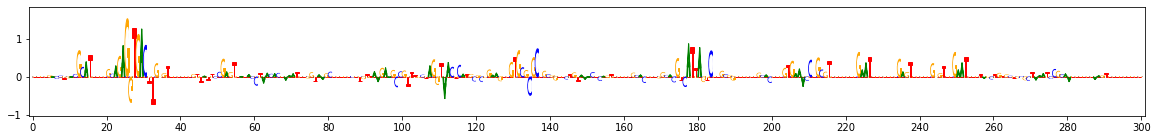

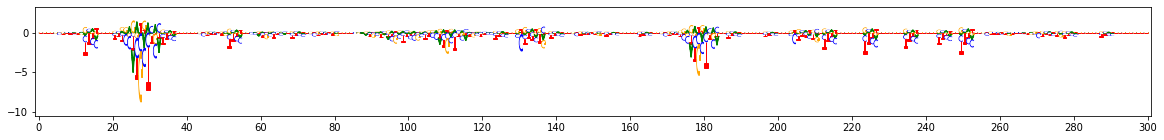

fg


KeyboardInterrupt: ignored

In [208]:
from modisco.visualization import viz_sequence

for i in range(5):
  print("fg")
  viz_sequence.plot_weights(fg_actual_scores[i], subticks_frequency=20)
  viz_sequence.plot_weights(fg_hyp_scores[i], subticks_frequency=20)
  #print("bg")
  #viz_sequence.plot_weights(bg_actual_scores[i], subticks_frequency=20)
  #viz_sequence.plot_weights(bg_hyp_scores[i], subticks_frequency=20)

In [209]:
from modisco.core import SeqletCoordinates

#identify (centered) seqlet coordinates for each motif
seqlet_len = 15
pwm_seqlet_coords = [ [] for pwm in pwms]

for pwm_hits in fg_pwm_to_hits:
    for pwm_hit in pwm_hits:
        if (pwm_hit.logodds_score > 2):
          pwm_len = pwm_hit.pwm_end - pwm_hit.pwm_start
          left_flank = int((seqlet_len - pwm_len)/2.0)
          seqlet_start = pwm_hit.pwm_start - left_flank
          seqlet_end = seqlet_start + seqlet_len
          if (seqlet_start >= 0) and (seqlet_end <= fg_onehot_seqs.shape[1]):
            pwm_seqlet_coords[pwm_hit.which_pwm].append(
                SeqletCoordinates(example_idx=pwm_hit.seq_idx,
                                  start=seqlet_start, end=seqlet_end,
                                  is_revcomp=False))

#get the seqlets from the trackset object
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
              task_names=["task0"], contrib_scores={"task0": fg_actual_scores},
              hypothetical_contribs={"task0": fg_hyp_scores},
              one_hot=fg_onehot_seqs, revcomp=False)
pwm_seqlets = [track_set.create_seqlets(coords=coords)
               for coords in pwm_seqlet_coords]



In [211]:
print(sum([len(x) for x in pwm_seqlets]))
#do a stratified sampling
#num_per_pwm = np.array([200, 40, 200, 40, 150, 0, 0, 0])
num_per_pwm = np.array([0, 0, 200, 50])
assert len(num_per_pwm)==len(pwm_seqlets)

def subsample_list(the_list, num_to_sample):
    subsample_idxs = np.random.RandomState(1234).choice(
      a=np.arange(len(the_list)), replace=False,
      size=min(num_to_sample,len(the_list)) )
    subsamp_items = [the_list[i] for i in subsample_idxs]
    return subsamp_items

sub_seqlets = [x for (the_pwm_seqlets, num_to_sample)
                     in zip(pwm_seqlets, num_per_pwm)
                     for x in subsample_list(the_pwm_seqlets, num_to_sample) ]
sub_seqlets_whichpwms = np.array([pwm_idx for pwm_idx in range(len(num_per_pwm))
                                  for x in range(num_per_pwm[pwm_idx])])

#subsample to 2k

from collections import Counter
print(Counter(sub_seqlets_whichpwms))


14952
Counter({2: 200, 3: 50})


In [212]:
# compute the pairwise sims using continjacc
def compute_pairwise_sims_continjacc(seqlets):
#    print("Num seqlets:", len(seqlets))
    #get the emebedding
    pattern_comparison_settings =(
        modisco.affinitymat.core.PatternComparisonSettings(                         
                    track_names=["task0_hypothetical_contribs",
                                "task0_contrib_scores"],                      
                    track_transformer=modisco.affinitymat.L1Normalizer(),                   
                    min_overlap=0.7))
    affmat_from_seqlets_with_nn_pairs =(
        modisco.affinitymat.core.AffmatFromSeqletsWithNNpairs(                      
            pattern_comparison_settings=pattern_comparison_settings,        
            sim_metric_on_nn_pairs=(
                modisco.affinitymat.core.ParallelCpuCrossMetricOnNNpairs(           
                    n_cores=10,                                   
                    cross_metric_single_region=                             
                        modisco.affinitymat.core.CrossContinJaccardSingleRegion()))))
    return affmat_from_seqlets_with_nn_pairs(seqlets=seqlets)

all_pairwise_sims = compute_pairwise_sims_continjacc(sub_seqlets)

nearest_neighbors = np.argsort(-all_pairwise_sims, axis=-1)
nn_pairwise_sims = np.array([ 
    row[nn] for row,nn in zip(all_pairwise_sims, nearest_neighbors) ])

Launching nearest neighbors affmat calculation job
MEMORY 1.619275776
Parallel runs completed
MEMORY 1.619202048
Job completed in: 1.69 s
MEMORY 1.619202048


Pwm 0 within v between


/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


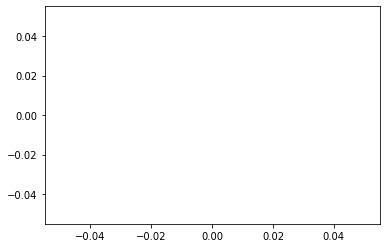

Pwm 1 within v between


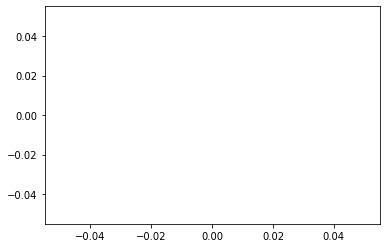

Pwm 2 within v between


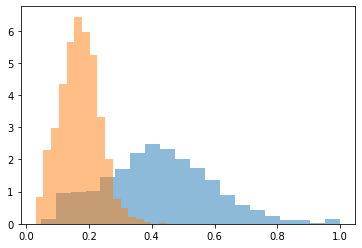

Pwm 3 within v between


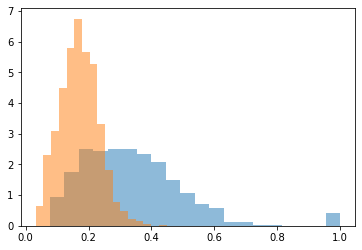

In [213]:
from matplotlib import pyplot as plt

#histogram within-cluster sims for different classes
for i in range(len(pwms)):
  print("Pwm",i,"within v between")
  plt.hist((all_pairwise_sims[sub_seqlets_whichpwms==i,:][:,sub_seqlets_whichpwms==i]).ravel(), bins=20, alpha=0.5, density=True)
  plt.hist((all_pairwise_sims[sub_seqlets_whichpwms==i,:][:,sub_seqlets_whichpwms!=i]).ravel(), bins=20, alpha=0.5, density=True)
  plt.show()

In [233]:
from matplotlib import pyplot as plt
import sklearn.manifold

# do the (two different) aff-to-dist mappings
# get t-sne emebdding, color points by ground-truth motif membership

PERPLEXITY = 10

invlogistic_distmat = modisco.affinitymat.AffToDistViaInvLogistic()(
                        all_pairwise_sims)
invlogistic_embedding = sklearn.manifold.TSNE(                             
                perplexity=PERPLEXITY,                                          
                metric='precomputed',                                           
                verbose=3, random_state=1234).fit_transform(invlogistic_distmat)

maxtomin_distmat = modisco.affinitymat.MaxToMin()(all_pairwise_sims)
maxtomin_embedding = sklearn.manifold.TSNE(                             
                perplexity=10,                                          
                metric='precomputed',                                           
                verbose=3, random_state=1234).fit_transform(maxtomin_distmat)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.001s...
[t-SNE] Computed neighbors for 250 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 0.288090
[t-SNE] Computed conditional probabilities in 0.007s
[t-SNE] Iteration 50: error = 74.6813889, gradient norm = 0.4742725 (50 iterations in 0.079s)
[t-SNE] Iteration 100: error = 71.5295715, gradient norm = 0.5318931 (50 iterations in 0.066s)
[t-SNE] Iteration 150: error = 72.2108459, gradient norm = 0.4932857 (50 iterations in 0.064s)
[t-SNE] Iteration 200: error = 72.7867889, gradient norm = 0.4823326 (50 iterations in 0.063s)
[t-SNE] Iteration 250: error = 72.8941574, gradient norm = 0.4928340 (50 iterations in 0.061s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.894157
[t-SNE] Iteration 300: error = 0.9992996, gradient norm = 0.0074238 (50 iterations in 0.051s)
[t-SNE] Iteration 350: error = 0.8479583, gradient norm = 0.0017578 (

Invlogisitc afftodist tsne


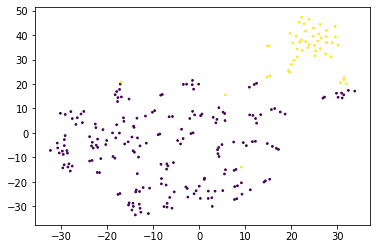

In [241]:
print("Invlogisitc afftodist tsne")
plt.scatter(invlogistic_embedding[:,0], invlogistic_embedding[:,1], s=3,
            c=sub_seqlets_whichpwms)
plt.show()

#print("1.0 minus afftodist tsne")      
#plt.scatter(maxtomin_embedding[:,0], maxtomin_embedding[:,1], s=3,
#            c=sub_seqlets_whichpwms)
#plt.show()

In [224]:
#run leiden on the unadapted sims
sym_seqlet_neighbors, sym_pairwise_sims_nn = modisco.util.symmetrize_nn_distmat(
    distmat_nn=nn_pairwise_sims, nn=nearest_neighbors,
    average_with_transpose=True)


In [225]:
clusterer = modisco.cluster.core.LeidenClusterParallel(
      n_jobs=10,                         
      affmat_transformer=
        modisco.affinitymat.transformers.AdhocAffMatTransformer(lambda x: x),            
      numseedstotry=50,                              
      n_leiden_iterations=-1,                
      verbose=True)
nodensadapted_leidenclusters = clusterer(
    modisco.util.coo_matrix_from_neighborsformat(
                    entries=sym_pairwise_sims_nn,
                    neighbors=sym_seqlet_neighbors,
                    ncols=len(sym_pairwise_sims_nn)).tocsr(),
    initclusters=None)

Beginning preprocessing + Leiden
Affmat shape: 250


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.5s


Quality: 0.08061940073475235
Quality: 0.0848027637828108


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   13.6s finished


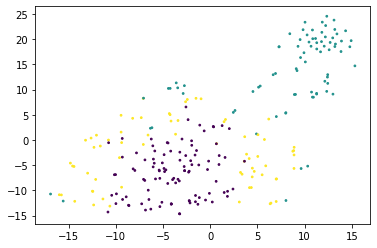

In [226]:
plt.scatter(invlogistic_embedding[:,0], invlogistic_embedding[:,1], s=3,
            c=nodensadapted_leidenclusters.cluster_indices)
plt.show()

In [237]:
import joblib

def do_density_adaptation(new_rows_distmat_nn, new_rows_nn,                 
                              new_rows_betas, new_rows_normfactors):            
    new_rows_densadapted_affmat_nn = []                                     
    for i in range(len(new_rows_distmat_nn)):                               
        densadapted_row = []                                                
        for j,distance in zip(new_rows_nn[i], new_rows_distmat_nn[i]):      
            densadapted_row.append(np.sqrt(                                 
              (np.exp(-distance/new_rows_betas[i])/new_rows_normfactors[i]) 
              *(np.exp(-distance/new_rows_betas[j])/                         
                new_rows_normfactors[j])))                                   
        new_rows_densadapted_affmat_nn.append(densadapted_row)              
    return new_rows_densadapted_affmat_nn


def get_density_embeddings(distmat_nn, seqlet_neighbors):
    sym_seqlet_neighbors, sym_distmat_nn = modisco.util.symmetrize_nn_distmat(  
                  distmat_nn=distmat_nn, nn=seqlet_neighbors,                     
                  average_with_transpose=True)
    #Compute beta values for the density adaptation. *store it*         
    betas_and_ps = joblib.Parallel(n_jobs=10)(     
            joblib.delayed(modisco.util.binary_search_perplexity)(PERPLEXITY, distances)
            for distances in sym_distmat_nn)
    betas = np.array([x[0] for x in betas_and_ps])
    #compute norm factors
    densadapted_affmat_nn_unnorm = [np.exp(-np.array(distmat_row)/beta)
        for distmat_row, beta in zip(sym_distmat_nn, betas)]
    normfactors = np.array([max(np.sum(x),1e-8) for x in
                            densadapted_affmat_nn_unnorm])
    #do the density adaptation
    sym_densadapted_affmat_nn = do_density_adaptation(
        new_rows_distmat_nn=sym_distmat_nn,
        new_rows_nn=sym_seqlet_neighbors,
        new_rows_betas=betas,
        new_rows_normfactors=normfactors)
    modisco.util.verify_symmetric_nn_affmat(
        affmat_nn=sym_densadapted_affmat_nn,
        nn=sym_seqlet_neighbors)
    csr_density_adapted_affmat =\
                modisco.util.coo_matrix_from_neighborsformat(
                    entries=sym_densadapted_affmat_nn,
                    neighbors=sym_seqlet_neighbors,
                    ncols=len(sym_densadapted_affmat_nn)).tocsr()

    return csr_density_adapted_affmat

#get density embeddings
nn_invlogistic_distmat = modisco.affinitymat.AffToDistViaInvLogistic()(nn_pairwise_sims)
invlogistic_csr_density_adapted_affmat = get_density_embeddings(
    distmat_nn=nn_invlogistic_distmat, seqlet_neighbors=nearest_neighbors)


Beginning preprocessing + Leiden
Affmat shape: 250


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.3s


Quality: 0.02661217226872096


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   13.4s finished


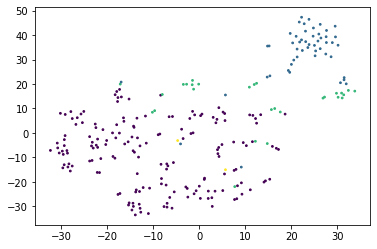

In [232]:
#run leiden on the adapted sims
densadapted_leidenclusters = clusterer(invlogistic_csr_density_adapted_affmat,
                                       initclusters=None)

plt.scatter(invlogistic_embedding[:,0], invlogistic_embedding[:,1], s=3,
            c=densadapted_leidenclusters.cluster_indices)
plt.show()

Beginning preprocessing + Leiden
Affmat shape: 250


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.5s


Quality: 0.0028312308462408267
Quality: 0.0028329656814082473


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   13.4s finished


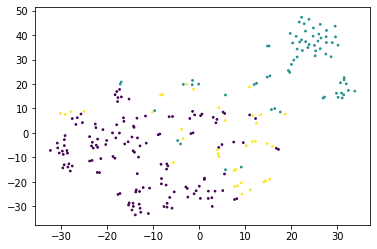

In [238]:
#run leiden on the adapted sims
nn_maxtomin_distmat = modisco.affinitymat.MaxToMin()(nn_pairwise_sims)
maxtomin_csr_density_adapted_affmat = get_density_embeddings(
    distmat_nn=nn_maxtomin_distmat, seqlet_neighbors=nearest_neighbors)

maxtomin_densadapted_leidenclusters = clusterer(maxtomin_csr_density_adapted_affmat,
                                       initclusters=None)



In [175]:
true_withincluster = (sub_seqlets_whichpwms[:,None]
                      == sub_seqlets_whichpwms[None,:])
print(np.sum(true_withincluster))

42500


In [65]:
nodensadapted_withincluster = (nodensadapted_leidenclusters.cluster_indices[:,None]
                               == nodensadapted_leidenclusters.cluster_indices[None,:])

densadapted_withincluster = (densadapted_leidenclusters.cluster_indices[:,None]
                               == densadapted_leidenclusters.cluster_indices[None,:])

In [66]:
np.sum((nodensadapted_withincluster==False)*(true_withincluster==True))

7206

In [67]:
np.sum((densadapted_withincluster==False)*(true_withincluster==True)) #proof that dens adaptation avoids false cross-cluster splits (false within-cluster can be identified during spurious merge detection)

7074

MEMORY 0.675811328
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold
For increasing = True , the minimum IR precision was 0.4226569309545958 occurring at 0.0 implying a frac_neg of 0.7320724082709246
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4625128884960966 occurring at -5.441756302626555e-06 implying a frac_neg of 0.8605097286927924
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -5.8066840821480525  and  18.230786914675114 with frac passing 0.04081785714285714
Passing windows frac was 0.04081785714285714 , which is below  0.2 ; adjusting
Final raw thresholds are -9.90867088245027  and  9.90867088245027
Final transformed thresholds are -0.8  and  0.8


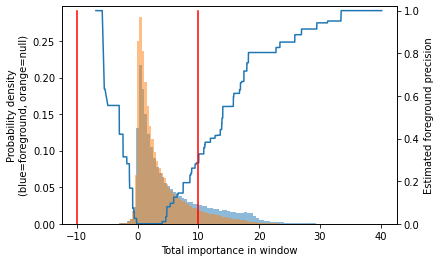

Got 3032 coords
After resolving overlaps, got 3032 seqlets
Across all tasks, the weakest transformed threshold used was: 0.7999
MEMORY 0.681275392
3032 identified in total
Reducing weak_threshold_for_counting_sign to match weakest_transformed_thresh, from 0.8 to 0.7999
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [3032]
Idx to activities:  {0: '1'}
MEMORY 0.681275392
On metacluster 0
Metacluster size 3032
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 3032
(Round 1) Computing coarse affmat
MEMORY 0.681275392
Beginning embedding computation
MEMORY 0.681275392


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   20.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   40.9s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done 3032 out of 3032 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3032 out of 3032 | elapsed:   11.1s finished


Constructing csr matrix...
csr matrix made in 0.8674659729003906 s
Finished embedding computation in 268.16 s
MEMORY 0.964521984
Starting affinity matrix computations
MEMORY 0.96425984
Batching in slices of size 3032


100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

Finished affinity matrix computations in 3.17 s
MEMORY 2.094972928
(Round 1) Computed coarse affmat
MEMORY 2.094710784
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 2.094710784


Launching nearest neighbors affmat calculation job
MEMORY 2.094710784
Parallel runs completed
MEMORY 2.094682112
Job completed in: 215.05 s
MEMORY 2.094256128
(Round 1) Computed affinity matrix on nearest neighbors in 215.62 s
MEMORY 2.094256128
Filtered down to 2938 of 3032
(Round 1) Retained 2938 rows out of 3032 after filtering
MEMORY 2.094596096
(Round 1) Computing density adapted affmat
MEMORY 2.094596096
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 1) Computing clustering
MEMORY 2.101665792
Beginning preprocessing + Leiden
Affmat shape: 2938


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.5min


Quality: 0.5520990256105588
Got 7 clusters after round 1
Counts:
{4: 332, 5: 322, 1: 542, 2: 502, 0: 570, 3: 349, 6: 321}
MEMORY 2.097717248
(Round 1) Aggregating seqlets in each cluster
MEMORY 2.097717248
Aggregating for cluster 0 with 570 seqlets
MEMORY 2.097717248


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  2.1min finished


Skipped 38 seqlets that went over sequence edge during flank expansion
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 531
Skipped 21 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 542 seqlets
MEMORY 2.097717248
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 32 seqlets that went over sequence edge during flank expansion
Skipped 3 due to duplicates
Trimming eliminated 0 seqlets out of 506
Skipped 11 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 502 seqlets
MEMORY 2.097733632
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 3 seqlets that went over the sequence edge during flank expansion
Skipped 36 seqlets that went over sequence edge during flank expansion
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 461
Skipped 15 seqlets that went over the sequence edge during flank expansion
Aggregati

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   14.6s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   32.6s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   55.3s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 2565 out of 2565 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2565 out of 2565 | elapsed:   10.6s finished


Constructing csr matrix...
csr matrix made in 0.796480655670166 s
Finished embedding computation in 191.96 s
MEMORY 2.190954496
Starting affinity matrix computations
MEMORY 2.190954496
Batching in slices of size 2565


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

Finished affinity matrix computations in 2.17 s
MEMORY 2.274791424
(Round 2) Computed coarse affmat
MEMORY 2.273742848
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 2.273742848


Launching nearest neighbors affmat calculation job
MEMORY 2.273742848
Parallel runs completed
MEMORY 2.273595392
Job completed in: 271.07 s
MEMORY 2.273083392
(Round 2) Computed affinity matrix on nearest neighbors in 271.64 s
MEMORY 2.273087488
Not applying filtering for rounds above first round
MEMORY 2.273087488
(Round 2) Computing density adapted affmat
MEMORY 2.273120256
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 2) Computing clustering
MEMORY 2.274062336
Beginning preprocessing + Leiden
Affmat shape: 2565


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.4min


Quality: 0.4831057556748017
Got 7 clusters after round 2
Counts:
{0: 508, 1: 507, 2: 457, 4: 272, 5: 264, 3: 306, 6: 251}
MEMORY 2.274070528
(Round 2) Aggregating seqlets in each cluster
MEMORY 2.274070528
Aggregating for cluster 0 with 508 seqlets
MEMORY 2.274070528


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  2.0min finished


Skipped 24 due to duplicates
Trimming eliminated 0 seqlets out of 484
Skipped 8 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 507 seqlets
MEMORY 2.274070528
Skipped 1 seqlets that went over sequence edge during flank expansion
Skipped 15 due to duplicates
Trimming eliminated 0 seqlets out of 491
Skipped 15 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 457 seqlets
MEMORY 2.274070528
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 7 seqlets that went over sequence edge during flank expansion
Skipped 15 due to duplicates
Trimming eliminated 0 seqlets out of 434
Skipped 9 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 3 with 306 seqlets
MEMORY 2.274070528
Skipped 7 due to duplicates
Trimming eliminated 0 seqlets out of 299
Skipped 19 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 476 out of 476 | elapsed:    2.0s finished


[t-SNE] Computed conditional probabilities for sample 476 / 476
[t-SNE] Mean sigma: 0.299500
Beginning preprocessing + Leiden
Affmat shape: 476


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   16.2s


Quality: 0.33103333633483123
Quality: 0.33193187758876347
Quality: 0.3323344641540617
Quality: 0.33302873873154265
Got subclusters: Counter({0: 125, 1: 76, 2: 60, 3: 52, 4: 40, 5: 37, 7: 27, 6: 27, 8: 24, 9: 8})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   22.5s finished


Numbers for each pattern pre-subsample: [125, 76, 60, 52, 40, 37, 27, 27, 24, 8]
Numbers after subsampling: [125, 76, 60, 52, 40, 37, 27, 27, 24, 8]
Computing sims for pattern 0
Computed sims for pattern 0 in 4.51369047164917 s
Computing sims for pattern 1
Computed sims for pattern 1 in 2.7092790603637695 s
Computing sims for pattern 2
Computed sims for pattern 2 in 1.941260576248169 s
Computing sims for pattern 3
Computed sims for pattern 3 in 1.9346826076507568 s
Computing sims for pattern 4
Computed sims for pattern 4 in 1.344003677368164 s
Computing sims for pattern 5
Computed sims for pattern 5 in 1.590810775756836 s
Computing sims for pattern 6
Computed sims for pattern 6 in 1.0728063583374023 s
Computing sims for pattern 7
Computed sims for pattern 7 in 1.1782910823822021 s
Computing sims for pattern 8
Computed sims for pattern 8 in 0.978118896484375 s
Computing sims for pattern 9
Computed sims for pattern 9 in 0.3827216625213623 s
Cluster sizes
[125  76  60  52  40  37  27  27 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 476 out of 476 | elapsed:    2.0s finished


[t-SNE] Computed conditional probabilities for sample 476 / 476
[t-SNE] Mean sigma: 0.285946
Beginning preprocessing + Leiden
Affmat shape: 476


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   16.4s


Quality: 0.3263032324901611
Quality: 0.3275245115008424
Quality: 0.32888912850658186
Got subclusters: Counter({0: 126, 1: 83, 2: 73, 3: 70, 4: 50, 5: 26, 6: 23, 7: 11, 8: 8, 9: 6})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   22.9s finished


Numbers for each pattern pre-subsample: [126, 83, 73, 70, 50, 26, 23, 11, 8, 6]
Numbers after subsampling: [126, 83, 73, 70, 50, 26, 23, 11, 8, 6]
Computing sims for pattern 0
Computed sims for pattern 0 in 4.625304460525513 s
Computing sims for pattern 1
Computed sims for pattern 1 in 3.1609437465667725 s
Computing sims for pattern 2
Computed sims for pattern 2 in 2.4614644050598145 s
Computing sims for pattern 3
Computed sims for pattern 3 in 2.3891570568084717 s
Computing sims for pattern 4
Computed sims for pattern 4 in 1.779264211654663 s
Computing sims for pattern 5
Computed sims for pattern 5 in 1.0251362323760986 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.9105982780456543 s
Computing sims for pattern 7
Computed sims for pattern 7 in 0.4836611747741699 s
Computing sims for pattern 8
Computed sims for pattern 8 in 0.38115596771240234 s
Computing sims for pattern 9
Computed sims for pattern 9 in 0.3158135414123535 s
Cluster sizes
[126  83  73  70  50  26  23  

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 406 out of 425 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 425 out of 425 | elapsed:    1.7s finished


[t-SNE] Computed conditional probabilities for sample 425 / 425
[t-SNE] Mean sigma: 0.286134
Beginning preprocessing + Leiden
Affmat shape: 425


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   14.3s


Quality: 0.30767566600572693
Quality: 0.30862938648409866
Quality: 0.31254816868758284
Quality: 0.31357477176891413
Quality: 0.3136781864743026
Got subclusters: Counter({0: 88, 1: 86, 2: 81, 3: 69, 4: 40, 5: 15, 6: 15, 7: 14, 8: 6, 9: 5, 10: 4, 11: 2})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   22.4s finished


Numbers for each pattern pre-subsample: [88, 86, 81, 69, 40, 15, 15, 14, 6, 5, 4, 2]
Numbers after subsampling: [88, 86, 81, 69, 40, 15, 15, 14, 6, 5, 4, 2]
Computing sims for pattern 0
Computed sims for pattern 0 in 4.158599138259888 s
Computing sims for pattern 1
Computed sims for pattern 1 in 4.178135395050049 s
Computing sims for pattern 2
Computed sims for pattern 2 in 3.5844879150390625 s
Computing sims for pattern 3
Computed sims for pattern 3 in 3.1796534061431885 s
Computing sims for pattern 4
Computed sims for pattern 4 in 1.9962003231048584 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.7280182838439941 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.697650671005249 s
Computing sims for pattern 7
Computed sims for pattern 7 in 0.6751644611358643 s
Computing sims for pattern 8
Computed sims for pattern 8 in 0.36011290550231934 s
Computing sims for pattern 9
Computed sims for pattern 9 in 0.33687567710876465 s
Computing sims for pattern 10
Comp

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 280 out of 280 | elapsed:    1.1s finished


[t-SNE] Computed conditional probabilities for sample 280 / 280
[t-SNE] Mean sigma: 0.313077
Beginning preprocessing + Leiden
Affmat shape: 280


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   10.3s


Quality: 0.2913395647775255
Quality: 0.2946701333650327
Quality: 0.294828249417623
Quality: 0.29503343238722346
Got subclusters: Counter({0: 80, 1: 48, 2: 46, 3: 32, 4: 24, 5: 23, 6: 16, 7: 7, 8: 4})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   15.4s finished


Numbers for each pattern pre-subsample: [80, 48, 46, 32, 24, 23, 16, 7, 4]
Numbers after subsampling: [80, 48, 46, 32, 24, 23, 16, 7, 4]
Computing sims for pattern 0
Computed sims for pattern 0 in 3.118025302886963 s
Computing sims for pattern 1
Computed sims for pattern 1 in 1.7258646488189697 s
Computing sims for pattern 2
Computed sims for pattern 2 in 1.4003422260284424 s
Computing sims for pattern 3
Computed sims for pattern 3 in 1.0692408084869385 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.7947168350219727 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.8399927616119385 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.6292548179626465 s
Computing sims for pattern 7
Computed sims for pattern 7 in 0.3150169849395752 s
Computing sims for pattern 8
Computed sims for pattern 8 in 0.23056674003601074 s
Cluster sizes
[80 48 46 32 24 23 16  7  4]
Cross-contamination matrix:
[[1.   0.06 0.26 0.39 0.29 0.34 0.18 0.02 0.14]
 [1.   1.   1. 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 247 out of 247 | elapsed:    0.9s finished


[t-SNE] Computed conditional probabilities for sample 247 / 247
[t-SNE] Mean sigma: 0.318116
Beginning preprocessing + Leiden
Affmat shape: 247


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    9.5s


Quality: 0.2808124322376043
Quality: 0.2884428922408911
Quality: 0.2895890526338798
Quality: 0.289612380793406
Quality: 0.28969506176057924
Quality: 0.2897083779556364
Quality: 0.2900548610129947
Got subclusters: Counter({0: 72, 1: 46, 2: 42, 3: 28, 4: 22, 5: 10, 7: 9, 6: 9, 8: 6, 9: 3})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   15.0s finished


Numbers for each pattern pre-subsample: [72, 46, 42, 28, 22, 10, 9, 9, 6, 3]
Numbers after subsampling: [72, 46, 42, 28, 22, 10, 9, 9, 6, 3]
Computing sims for pattern 0
Computed sims for pattern 0 in 2.43039608001709 s
Computing sims for pattern 1
Computed sims for pattern 1 in 1.4033308029174805 s
Computing sims for pattern 2
Computed sims for pattern 2 in 1.5240328311920166 s
Computing sims for pattern 3
Computed sims for pattern 3 in 1.0436835289001465 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.8490505218505859 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.41695117950439453 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.33484554290771484 s
Computing sims for pattern 7
Computed sims for pattern 7 in 0.36527109146118164 s
Computing sims for pattern 8
Computed sims for pattern 8 in 0.25693178176879883 s
Computing sims for pattern 9
Computed sims for pattern 9 in 0.15761876106262207 s
Cluster sizes
[72 46 42 28 22 10  9  9  6  3]


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 218 out of 237 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 237 out of 237 | elapsed:    0.7s finished


[t-SNE] Computed conditional probabilities for sample 237 / 237
[t-SNE] Mean sigma: 0.317370
Beginning preprocessing + Leiden
Affmat shape: 237


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    9.7s


Quality: 0.252424229728012
Quality: 0.25982871314793193
Got subclusters: Counter({0: 61, 1: 55, 2: 35, 3: 31, 4: 19, 5: 14, 6: 13, 7: 7, 8: 2})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   14.1s finished


Numbers for each pattern pre-subsample: [61, 55, 35, 31, 19, 14, 13, 7, 2]
Numbers after subsampling: [61, 55, 35, 31, 19, 14, 13, 7, 2]
Computing sims for pattern 0
Computed sims for pattern 0 in 1.5913102626800537 s
Computing sims for pattern 1
Computed sims for pattern 1 in 1.5579471588134766 s
Computing sims for pattern 2
Computed sims for pattern 2 in 1.0974175930023193 s
Computing sims for pattern 3
Computed sims for pattern 3 in 1.011218547821045 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.5887110233306885 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.4476137161254883 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.42908787727355957 s
Computing sims for pattern 7
Computed sims for pattern 7 in 0.24768280982971191 s
Computing sims for pattern 8
Computed sims for pattern 8 in 0.12445497512817383 s
Cluster sizes
[61 55 35 31 19 14 13  7  2]
Cross-contamination matrix:
[[1.   1.   1.   1.   1.   1.   0.94 1.   0.78]
 [0.01 1.   0

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 234 out of 234 | elapsed:    0.7s finished


[t-SNE] Computed conditional probabilities for sample 234 / 234
[t-SNE] Mean sigma: 0.311469
Beginning preprocessing + Leiden
Affmat shape: 234


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   10.4s


Quality: 0.2678988210049787
Quality: 0.26819115180208924
Quality: 0.2685556951139933
Quality: 0.2688442269966865
Quality: 0.26888612144433094
Quality: 0.26955325414186865
Got subclusters: Counter({0: 64, 1: 48, 2: 42, 3: 40, 4: 22, 5: 11, 6: 5, 7: 2})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   13.8s finished


Numbers for each pattern pre-subsample: [64, 48, 42, 40, 22, 11, 5, 2]
Numbers after subsampling: [64, 48, 42, 40, 22, 11, 5, 2]
Computing sims for pattern 0
Computed sims for pattern 0 in 1.5401272773742676 s
Computing sims for pattern 1
Computed sims for pattern 1 in 1.1805973052978516 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.9680473804473877 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.9191761016845703 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.6211729049682617 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.3287215232849121 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.17824196815490723 s
Computing sims for pattern 7
Computed sims for pattern 7 in 0.10704779624938965 s
Cluster sizes
[64 48 42 40 22 11  5  2]
Cross-contamination matrix:
[[1.   0.57 0.34 0.3  0.2  0.07 0.23 0.37]
 [0.99 1.   0.57 0.48 0.36 0.14 0.42 0.54]
 [1.   1.   1.   0.81 0.66 0.37 0.83 0.89]
 [1.   0.97 0.84 1.   0.

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 445 out of 464 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 464 out of 464 | elapsed:    2.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 464 samples in 0.009s...
[t-SNE] Computed neighbors for 464 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 464 / 464
[t-SNE] Mean sigma: 0.306502
[t-SNE] Computed conditional probabilities in 0.053s
[t-SNE] Iteration 50: error = 67.7731628, gradient norm = 0.4663813 (50 iterations in 0.256s)
[t-SNE] Iteration 100: error = 70.0526886, gradient norm = 0.4472150 (50 iterations in 0.227s)
[t-SNE] Iteration 150: error = 71.0096893, gradient norm = 0.4424374 (50 iterations in 0.226s)
[t-SNE] Iteration 200: error = 71.1384430, gradient norm = 0.4326263 (50 iterations in 0.241s)
[t-SNE] Iteration 250: error = 72.5673523, gradient norm = 0.4202160 (50 iterations in 0.254s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.567352
[t-SNE] Iteration 300: error = 1.3822672, gradient norm = 0.0057358 (50 iterations in 0.187s)
[t-SNE] Iteration 350: error = 1.3218449, gradient norm = 0.0011948 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   13.2s


Quality: 0.33343807554080623
Quality: 0.33364728238783387
Quality: 0.3337422966716533
Quality: 0.3345032815241389
Quality: 0.3350454323958911
Quality: 0.33519734904981646
Quality: 0.33554059153061605
Quality: 0.3356611081093658


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   20.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Got subclusters: Counter({0: 93, 1: 59, 2: 53, 3: 50, 4: 45, 5: 31, 6: 25, 7: 21, 8: 20, 9: 20, 10: 17, 11: 16, 12: 9, 13: 5})
On pattern 1


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 459 out of 459 | elapsed:    2.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 459 samples in 0.005s...
[t-SNE] Computed neighbors for 459 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 459 / 459
[t-SNE] Mean sigma: 0.289246
[t-SNE] Computed conditional probabilities in 0.045s
[t-SNE] Iteration 50: error = 66.9643707, gradient norm = 0.4781108 (50 iterations in 0.237s)
[t-SNE] Iteration 100: error = 70.9770737, gradient norm = 0.4422591 (50 iterations in 0.235s)
[t-SNE] Iteration 150: error = 71.2644806, gradient norm = 0.4415128 (50 iterations in 0.232s)
[t-SNE] Iteration 200: error = 71.5115509, gradient norm = 0.4036194 (50 iterations in 0.230s)
[t-SNE] Iteration 250: error = 72.0415955, gradient norm = 0.4207340 (50 iterations in 0.218s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.041595
[t-SNE] Iteration 300: error = 1.3925319, gradient norm = 0.0052112 (50 iterations in 0.221s)
[t-SNE] Iteration 350: error = 1.2965603, gradient norm = 0.0011883 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   15.2s


Quality: 0.316607377675109
Quality: 0.3177896884773226
Quality: 0.3184504399564155
Quality: 0.3202302215548848
Quality: 0.32369810138823046
Quality: 0.3249754741081291


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   22.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Got subclusters: Counter({0: 92, 1: 84, 2: 75, 3: 65, 4: 56, 5: 53, 6: 17, 7: 12, 8: 5})
On pattern 2


[Parallel(n_jobs=10)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 393 out of 393 | elapsed:    1.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 393 samples in 0.005s...
[t-SNE] Computed neighbors for 393 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 393 / 393
[t-SNE] Mean sigma: 0.288800
[t-SNE] Computed conditional probabilities in 0.038s
[t-SNE] Iteration 50: error = 68.3266068, gradient norm = 0.4756466 (50 iterations in 0.192s)
[t-SNE] Iteration 100: error = 68.5129547, gradient norm = 0.4831542 (50 iterations in 0.209s)
[t-SNE] Iteration 150: error = 67.8429260, gradient norm = 0.4808223 (50 iterations in 0.169s)
[t-SNE] Iteration 200: error = 70.4169769, gradient norm = 0.4503259 (50 iterations in 0.188s)
[t-SNE] Iteration 250: error = 73.8042908, gradient norm = 0.4227988 (50 iterations in 0.218s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.804291
[t-SNE] Iteration 300: error = 1.3637121, gradient norm = 0.0050046 (50 iterations in 0.164s)
[t-SNE] Iteration 350: error = 1.2787910, gradient norm = 0.0016291 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   12.6s


Quality: 0.3107264120389419
Quality: 0.31179115601685997
Quality: 0.3117990093625997


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   25.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Got subclusters: Counter({0: 112, 1: 86, 2: 62, 3: 46, 4: 40, 5: 27, 6: 16, 7: 4})
On pattern 3


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 249 out of 268 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 268 out of 268 | elapsed:    1.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 268 samples in 0.004s...
[t-SNE] Computed neighbors for 268 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 268 / 268
[t-SNE] Mean sigma: 0.320630
[t-SNE] Computed conditional probabilities in 0.040s
[t-SNE] Iteration 50: error = 68.5848389, gradient norm = 0.4551058 (50 iterations in 0.373s)
[t-SNE] Iteration 100: error = 67.7610168, gradient norm = 0.4852744 (50 iterations in 0.108s)
[t-SNE] Iteration 150: error = 68.2099838, gradient norm = 0.4452499 (50 iterations in 0.109s)
[t-SNE] Iteration 200: error = 67.8853683, gradient norm = 0.4380916 (50 iterations in 0.104s)
[t-SNE] Iteration 250: error = 68.4935608, gradient norm = 0.4468282 (50 iterations in 0.111s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.493561
[t-SNE] Iteration 300: error = 1.1592562, gradient norm = 0.0065617 (50 iterations in 0.110s)
[t-SNE] Iteration 350: error = 1.0130260, gradient norm = 0.0063858 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    9.4s


Quality: 0.2986670203087926
Quality: 0.2989261711433826


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   14.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Got subclusters: Counter({0: 93, 1: 52, 2: 30, 3: 26, 4: 24, 5: 18, 6: 13, 7: 12})
On pattern 4


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 238 out of 238 | elapsed:    0.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 238 samples in 0.004s...
[t-SNE] Computed neighbors for 238 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 238 / 238
[t-SNE] Mean sigma: 0.321791
[t-SNE] Computed conditional probabilities in 0.024s
[t-SNE] Iteration 50: error = 62.4505959, gradient norm = 0.4818849 (50 iterations in 0.091s)
[t-SNE] Iteration 100: error = 62.6811790, gradient norm = 0.4826612 (50 iterations in 0.121s)
[t-SNE] Iteration 150: error = 62.5231705, gradient norm = 0.4836711 (50 iterations in 0.094s)
[t-SNE] Iteration 200: error = 64.5087128, gradient norm = 0.4457769 (50 iterations in 0.131s)
[t-SNE] Iteration 250: error = 60.6952629, gradient norm = 0.4933939 (50 iterations in 0.093s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.695263
[t-SNE] Iteration 300: error = 0.9818820, gradient norm = 0.0051325 (50 iterations in 0.079s)
[t-SNE] Iteration 350: error = 0.8260759, gradient norm = 0.0060984 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.4s


Quality: 0.28759327541737023
Quality: 0.2883958869149077
Quality: 0.2885393058959119
Quality: 0.288653150991382


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   13.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Got subclusters: Counter({0: 75, 1: 44, 2: 40, 3: 36, 4: 14, 5: 11, 7: 9, 6: 9})
On pattern 5


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 228 out of 228 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 228 samples in 0.005s...
[t-SNE] Computed neighbors for 228 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 228 / 228
[t-SNE] Mean sigma: 0.327268
[t-SNE] Computed conditional probabilities in 0.022s
[t-SNE] Iteration 50: error = 58.9541931, gradient norm = 0.5507381 (50 iterations in 0.084s)
[t-SNE] Iteration 100: error = 59.9514694, gradient norm = 0.5045834 (50 iterations in 0.094s)
[t-SNE] Iteration 150: error = 62.0645828, gradient norm = 0.5013255 (50 iterations in 0.081s)
[t-SNE] Iteration 200: error = 62.2759132, gradient norm = 0.4680664 (50 iterations in 0.091s)
[t-SNE] Iteration 250: error = 62.2887726, gradient norm = 0.4821265 (50 iterations in 0.095s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.288773
[t-SNE] Iteration 300: error = 1.0484163, gradient norm = 0.0067129 (50 iterations in 0.088s)
[t-SNE] Iteration 350: error = 0.8191736, gradient norm = 0.0061448 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    9.8s


Quality: 0.2674533884775389
Quality: 0.2683177520865456
Quality: 0.2693480002490266
Quality: 0.2693927975674957
Quality: 0.2696475135036586
Quality: 0.2697281078349506
Quality: 0.2701858606580409


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   13.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Got subclusters: Counter({0: 60, 1: 44, 2: 33, 3: 29, 4: 24, 5: 19, 6: 12, 7: 7})
On pattern 6


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 216 out of 216 | elapsed:    0.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 216 samples in 0.004s...
[t-SNE] Computed neighbors for 216 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 216 / 216
[t-SNE] Mean sigma: 0.317004
[t-SNE] Computed conditional probabilities in 0.022s
[t-SNE] Iteration 50: error = 59.7841301, gradient norm = 0.4814480 (50 iterations in 0.078s)
[t-SNE] Iteration 100: error = 59.8186302, gradient norm = 0.4758967 (50 iterations in 0.080s)
[t-SNE] Iteration 150: error = 61.5759811, gradient norm = 0.4578619 (50 iterations in 0.088s)
[t-SNE] Iteration 200: error = 62.8160667, gradient norm = 0.4767894 (50 iterations in 0.086s)
[t-SNE] Iteration 250: error = 63.0917740, gradient norm = 0.4728822 (50 iterations in 0.079s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.091774
[t-SNE] Iteration 300: error = 1.0403262, gradient norm = 0.0079333 (50 iterations in 0.086s)
[t-SNE] Iteration 350: error = 0.7995433, gradient norm = 0.0070379 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.2s


Quality: 0.2604697115981554
Quality: 0.26067454014094127
Quality: 0.2616960676028932
Quality: 0.26234242274982883


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   13.1s finished


Got subclusters: Counter({0: 65, 1: 42, 2: 28, 3: 23, 4: 22, 5: 20, 6: 10, 7: 6})


In [ ]:
import modisco

#null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
null_per_pos_scores = {"task0":np.sum(bg_actual_scores,axis=-1)}
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    target_seqlet_fdr=0.2,
                    min_passing_windows_frac=0.2,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        final_flank_to_add=5,
                        n_cores=10)
                )(
                 task_names=["task0"],#, "task1", "task2"],
                 contrib_scores={"task0": fg_actual_scores},
                 hypothetical_contribs={"task0": fg_hyp_scores},
                 one_hot=fg_onehot_seqs,
                 null_per_pos_scores=null_per_pos_scores,
                 revcomp=False #keeping it simple for the simulation
                  )

In [ ]:
patterns = tfmodisco_results.metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result.patterns

In [ ]:
remaining_patterns = tfmodisco_results.metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result.remaining_patterns

seqlets: 464


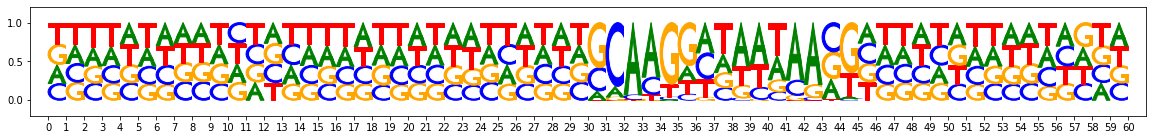

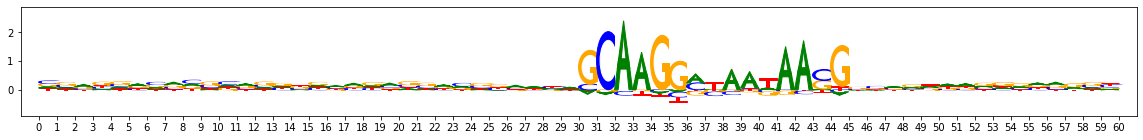

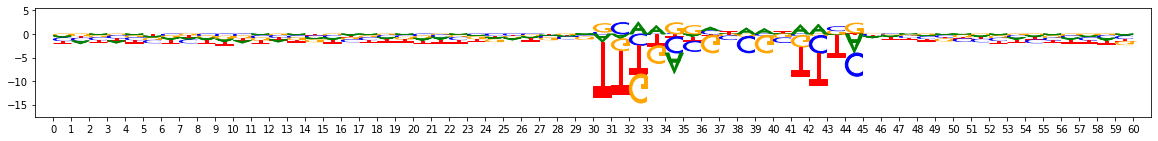

seqlets: 459


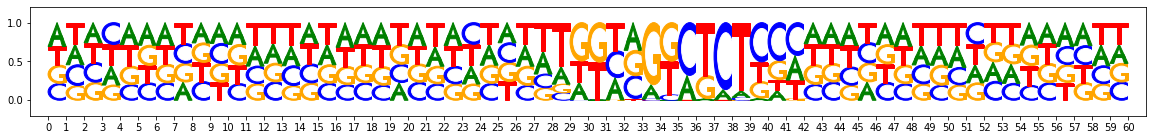

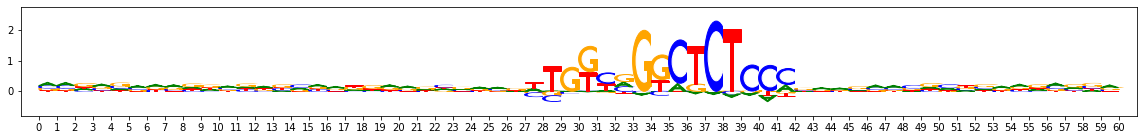

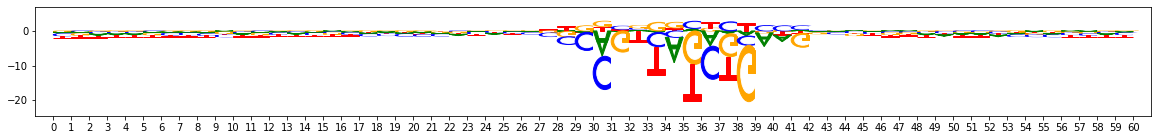

seqlets: 393


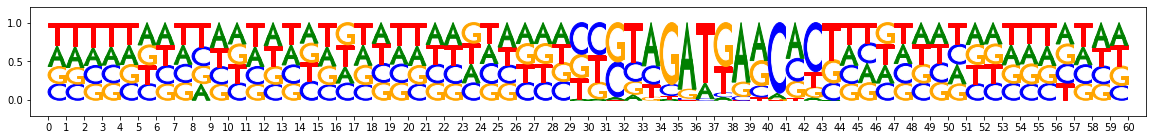

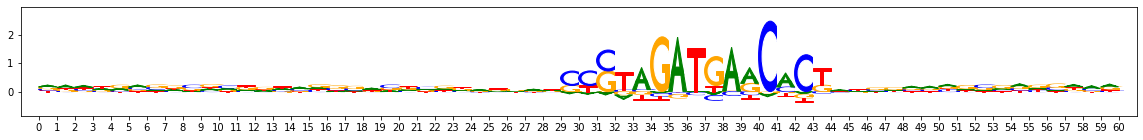

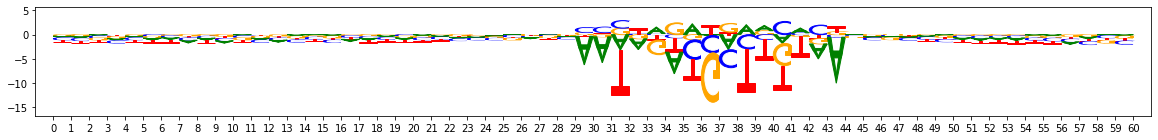

seqlets: 268


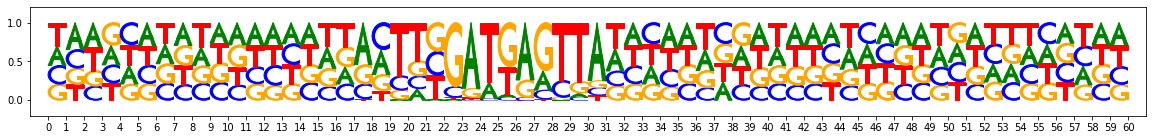

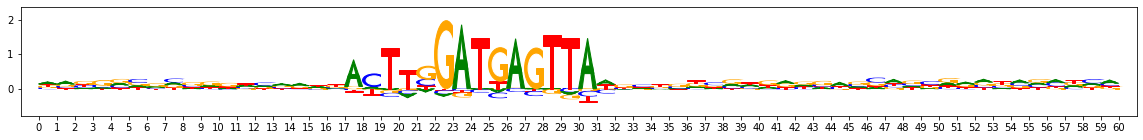

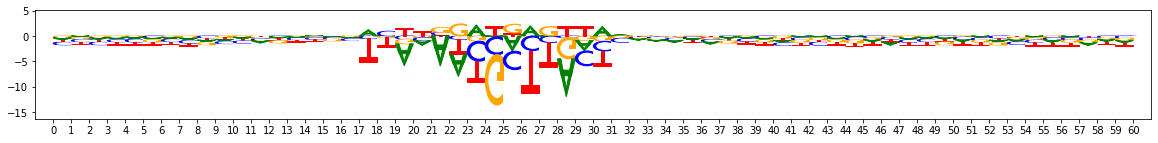

seqlets: 238


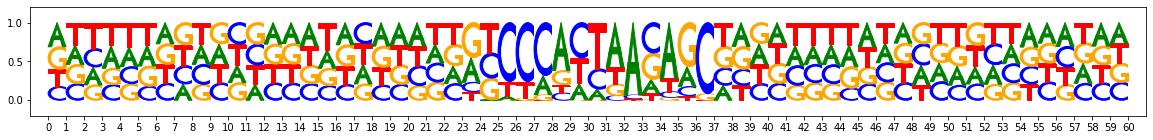

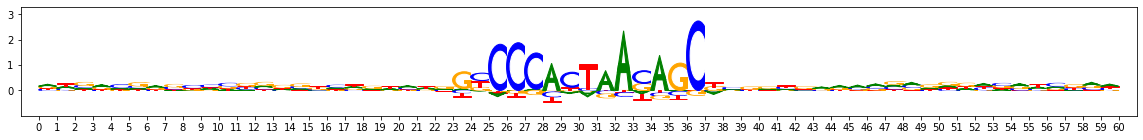

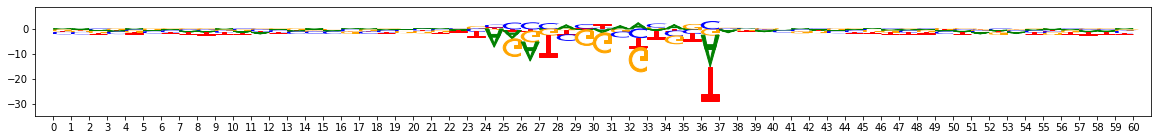

seqlets: 228


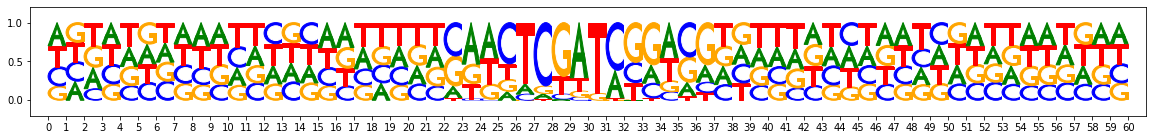

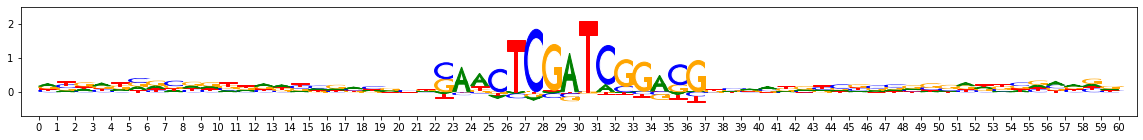

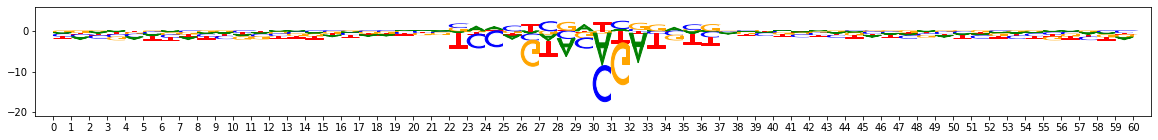

seqlets: 216


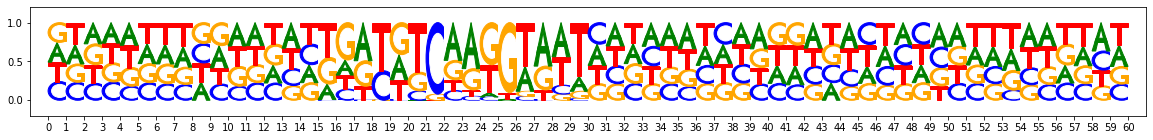

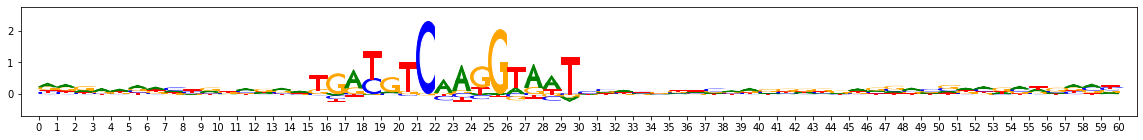

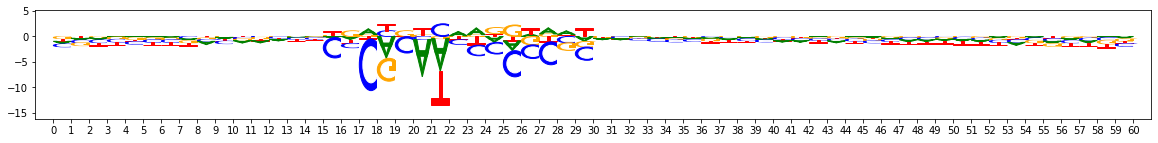

In [ ]:
for patternidx,pattern in enumerate(patterns):
  print("seqlets:", len(pattern.seqlets))
  viz_sequence.plot_weights(pattern["sequence"].fwd)
  viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
  viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd)


In [ ]:
#for pattern in remaining_patterns:
#  print("seqlets:", len(pattern.seqlets))
#  viz_sequence.plot_weights(pattern["sequence"].fwd)
#  viz_sequence.plot_weights(pattern["sequence"].rev)
#  viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
#  viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd
#                            - np.mean(pattern["task0_hypothetical_contribs"].fwd, axis=-1)[:,None])
